# Gaze Estimation

In [1]:
#Basic
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Aiding conversions from string to list
import ast

#Randomize
import random

#Labelling classifiers
import datetime

import joblib

#Support Vector Classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from sklearn import svm
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

## 1. Recording a video

Just record it. Falar de algumas precauções e cuidades. IDK

## 2. Converting the video in measurable data / Data treatment

### 2.1 Importing the text file

To do so, we created [datasetGenerating.py](https://github.com/antonioramiro/gaze-estimation/blob/master/datasetGenerating.py) which converts a video into an array of (~) 47 elements. yada yada yada

``demo da datasetGenerating`` .gif e o comando q se usa 

Then, to cluster every vector generated, each in an individual .txt file, we used [txtJoiner](https://github.com/antonioramiro/gaze-estimation/blob/master/txtJoiner.py), which outputs the following file yada yada. When said file is imported, the lines are read as strings, therefore it needs to be converted to a list of lists.

In [2]:
#opening the file
with open('dataset_2020-03-24.txt') as file:
    txt_file = [line.strip() for line in file]

dataset = []
#converting a list of strings to a list of lists
counter = 0
total_lines = len(txt_file)
while counter != total_lines:
    individual_line = ast.literal_eval(txt_file[counter])
    dataset += [individual_line]
    counter+=1

#### 2.1.1 Understanding the data

meter aqui imagem do boneco, com a legenda adequada ao nosso vetor. como por aquilo bonito? fica melhor explicado por escrito do que tudo discriminado.

``[x_nose, y_nose, x_right ear, y_right ear, x_left ear, y_left ear, x_right eye, y_right eye, x_left eye, y_left eye, x_right hand, y_right hand, x_left hand, y_left hand, ... contextual information - 32 positions ..., quadrant]``

### 2.2 Increasing sample size

inverter horizontalmente as cenas + termos o dobro dos dados. nota: a geradora do dataset cospe a resolução das imagens na sua penúltima linha

In [3]:
print('Initially, the dataset is composed by ' + str(len(dataset)) + ' elements.')

Initially, the dataset is composed by 11 elements.


In [4]:
resolution = (640,352) 
flipped_dataset = []

# Calculate the simetric quadrant, where the input is an int and the output is a list of 1 element.
# Given the numeration of quadrants (stated in 2.1.1), a simple addition/subtraction of 3 or 5 will yield
# the simetric quadrant

def flipped_quadrant(quadrant):
    if quadrant in [1,3,9,11]:
        flipped_quadrant = quadrant + 3 
    elif quadrant in [4,6,12,14]:
        flipped_quadrant = quadrant - 3 
    elif quadrant in [0,2,8,10]:
        flipped_quadrant = quadrant + 5
    elif quadrant in [5,7,13,15]:
        flipped_quadrant = quadrant - 5  
    return [flipped_quadrant]
    

for element in dataset:
    flipped_element = []
    for i in range(len(element) - 33):
        
        # Every even index (up to the 14th: indexes that correspond to coordinates of poseKeypoints) contains 
        # an X coordinate, from which can be obtained the simetric coordinate (by subtracting to the width
        # the original X), note that Y is irrelevant to horizontal simetry.
        
        if i%2 == 0 and element[i] != -1: #x
            flipped_element += [resolution[0] - element[i]]
                                            
        else: #y or x == -1
            flipped_element += [element[i]]       
        
    flipped_dataset += [flipped_element + element[14:-1] + flipped_quadrant(element[-1])]

dataset += flipped_dataset

In [5]:
print('Now, it has ' + str(len(dataset)) + ' elements.')

Now, it has 22 elements.


### 2.2.1 Leveling the data - corrigir numeracao

Em vez de leveling, outra palavra para descrever este processo de fazer os numeros mais proximos.  Due to XXXX, some quadrants tend to be more prevalent. So in order not to confuse :p the SVM, the values should be more homogenized  Falar um pouco

Firstly lets visualise the distributtion of data with the following function

In [6]:
def heatmap(data):
    return 0

# https://stackoverflow.com/a/29528483/11606537

# faz com que dê output a uma imagem como essa e que também dê dados para serem usados na função que faz 
# o levelling propriamente dito. ser o maximo relativa possivel, nomeadamente o valor que queremos que 
# cada quadrante tenha de exemplos. Usa cenas do panda
# para aceder ao quadrante, dataset[i][-1], se nao me engano

Prior to leveling, we have

In [7]:
heatmap(dataset)

0

Now we shall define the levelling function

In [8]:
def levelling(a):
    return 0

#faz com que printe, no final, considerações sobre o efectuado, tipo foram ignorados um total de XXX frames (? % do
# dataset original) neste processo, 

And apply it to our data, seeing a more homogeneyus ...

In [9]:
levelling(0)
heatmap(0)

#guardar o novo dataset em dataset, var global

0

### 2.3 Separating data for testing and for training

Now let's get the party going. Separate data

In [10]:
size = len(dataset)

In [11]:
total_frames = len(dataset)
testing_data = []
training_data = []

for i in range(int(0.2*total_frames)):
    element_to_transfer = random.choice(dataset)
    testing_data += [element_to_transfer]
    dataset.remove(element_to_transfer)

training_data = dataset
dataset = []

In [12]:
(len(testing_data),len(testing_data)/size),(len(training_data),len(training_data)/size)

((4, 0), (18, 0))

## 3. Training the models & Classifying

### 3.1 Creating a proper list of vectors

Este step is only done here in order to reduce the probability of messing up and disconecting each X vector from the correspondant Y

In [13]:
def eXifY(data):
    X, Y = [element[0:-1] for element in data], [element[-1] for element in data]
    return X, Y

In [14]:
len(eXifY(training_data)[0]) == len(eXifY(training_data)[1])

True

### 3.2 Training & Classifying

Since the goal is the comparison of the quality of the classifications according to the type of context (number of 
coordinates given), we are going to train 4 models and test them to see the differences in success rate.
Below are defined the training and testing functions, respectively.

In [15]:
def training(X,Y):
   
    nfolds=3 #3 means a 3-fold cross-validation
    Cs = [1000,100] #parameter 1
    gammas = [1e-06] #parameter 2  
    param_grid = {'C': Cs, 'gamma' : gammas} #all in one grid
    grid_search2 = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds) #svm classifier
    grid_search2.fit(X, Y) #fitting the data
    best=grid_search2.best_params_ 

    clf = SVC(C= best['C'],gamma=best['gamma']) #creating the model with the best parameters
    clf.fit(X, Y) #fitting the model to the data

    now = datetime.datetime.now()
    timestamp = str(now.strftime("%d-%m-%Y_%Hh%Mm%Ss")) #the current day and time to have in the classifier name 
    
    #to insert in the name of the classifier and text files which of the 4 groups of coordinates is the classifier using
    if str(len(X[0])) == '10': #(head)
        datatype='Head'
    if str(len(X[0])) == '14': #(head + hands)
        datatype='Head_Hands'
    if str(len(X[0])) == '42': #(head + context data)
        datatype='Head_Context_data'
    if str(len(X[0])) == '46': #(all) 
        datatype='All'
     
    info_classif='classifier_' + timestamp + '_' + datatype +'_info.txt'
    with open(info_classif, 'w+')  as info:
        info.write('Group of Coordinates: '+ datatype + '\n')
        info.write('Type of classifier: SVM\n') # python will convert \n to os.linesep
        info.write('C:'+str(best['C'])+'\n')
        info.write('Gamma:'+str(best['gamma'])+'\n')

    
    classif = 'classifier_'+ timestamp + '_'+ datatype +'.joblib'
    dump(clf, classif) 
                       
    return classif,info_classif

In [16]:
def testing(X,Y,classif,info_classif):
    
    clf  = joblib.load(classif)
    result = clf.score(X, Y)
    
    Qpredicted= []
    i=0
    length=len(X)

    while i != length:
        Qpredicted+= [str(clf.predict(np.array([X[i]]))).strip('['+']'+'"')] #predict
        Y[i]= str(Y[i]) #converting to a string
        i+=1
        
    print('The percentage of success was: ' + str(result*100)+ ' %\n')
    with open(info_classif, 'a')  as info:
        info.write('\n----\n')
        info.write('The percentage of success was: ' + str(result*100)+ ' %\n')
        
    CONF= confusion_matrix(np.array(Y), np.array(Qpredicted))

    return CONF, result, Qpredicted

#### 3.2.1 Using only the face keypoints

Since we're only using  the keypoints of the head, we'll delete context information about the difference short/long distance object and hands coordinates. <br> 
The head coordinates are the first 10 (5*2) (x,y).

Below we will:<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br> 
 - Train the model with only the head coordinates using the training function (defined before);<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br> 
 - Test the model with only the head coordinates using the training function (defined before).

In [17]:
X, Y = eXifY(training_data)
X = [element[:10] for element in X]

In [18]:
classif,info_classif=training(X,Y)

C:\Users\toshiba\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\toshiba\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
X, Y = eXifY(testing_data)
X = [element[:10] for element in X]

In [20]:
CONF1, result, Qpredicted = testing(X,Y,classif,info_classif)
print(Qpredicted)
print(Y)
print(CONF1)

The percentage of success was: 100.0 %

['8', '3', '6', '13']
['8', '3', '6', '13']
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


#### 3.2.2 Using only keypoints (face + hands)

Since we're only using  the keypoints of the head and the hands, we'll delete context information about the difference short/long distance object.<br> 
The keypoints (head + hands) coordinates are the first 10 (5*2) + 4 (2*2)(x,y), giving a total of 14.<br> 
The rest of the procedure is the same as in 3.2.1.:

Below we will:<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br> 
 - Train the model with only the head + hand coordinates using the training function (defined before);<br> 
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br> 
 - Test the model with only the head + hand coordinates using the training function (defined before).

In [21]:
X, Y = eXifY(training_data)
X = [element[:14] for element in X]

In [22]:
classif,info_classif=training(X,Y)

C:\Users\toshiba\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [23]:
X, Y = eXifY(testing_data)
X = [element[:14] for element in X]

In [24]:
CONF2, result, Qpredicted = testing(X,Y,classif,info_classif)
print(Qpredicted)
print(Y)
print(CONF2)

The percentage of success was: 100.0 %

['8', '3', '6', '13']
['8', '3', '6', '13']
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


#### 3.2.3 Using only the keypoints of the head and context data

Since we're only using  the keypoints of the head and the context information about the difference short/long distance object, we'll delete the hand coordinates.<br> 
The keypoints of the head coordinates are the first 10 (5*2) and the context data goes from the 15 to the 46 coordinates (but on the code we have to do it from 14th to start on the 15th) giving a total of 42 coordinates.<br>
The rest of the procedure is the same as in 3.2.1.:

Below we will:<br>
 - Delete the coordinates we don't need (mentioned before) from the whole training data;<br>
 - Train the model with only the head + context data coordinates using the training function (defined before);<br>
 - Delete the coordinates we don't need (mentioned before) from the whole testing data;<br>
 - Test the model with only the head + context data coordinates using the training function (defined before).

In [25]:
X, Y = eXifY(training_data)
X = [element[:10] + element[14:] for element in X]

In [26]:
classif,info_classif=training(X,Y)

C:\Users\toshiba\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
X, Y = eXifY(testing_data)
X = [element[:10] + element[14:] for element in X]

In [28]:
CONF3, result, Qpredicted = testing(X,Y,classif,info_classif)
print(Qpredicted)
print(Y)
print(CONF3)

The percentage of success was: 100.0 %

['8', '3', '6', '13']
['8', '3', '6', '13']
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


#### 3.2.4 Using all the coordinates (keypoints of the head, hands and context data)

Now we are using the whole set of coordinates (keypoints of the head, hands and context data) giving a total of 46 coordinates.

Below we will:<br>
 - Create the training data divided into X (coordinates) and Y (quadrants) like before;<br>
 - Train the model with all the 46 coordinates using the training function (defined before);<br>
 - Create the test data divided into X (coordinates) and Y (quadrants) like before; <br>
 - Test the model with all the coordinates using the training function (defined before).

In [29]:
X, Y = eXifY(training_data)

In [30]:
classif,info_classif=training(X,Y)

C:\Users\toshiba\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
X, Y = eXifY(testing_data)

In [32]:
CONF4, result, Qpredicted = testing(X,Y,classif,info_classif)
print(Qpredicted)
print(Y)
print(CONF4)

The percentage of success was: 100.0 %

['8', '3', '6', '13']
['8', '3', '6', '13']
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


## 4. Comparing classifications

Now, at last, we compare the Confusion Matrices of the 4 groups of coordinates. And with a nice layout!

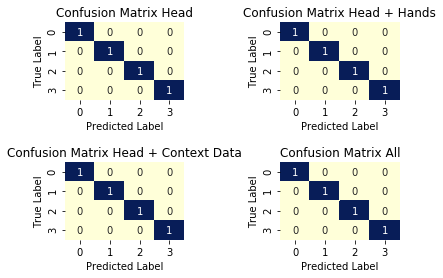

In [33]:
plt.subplot(2, 2, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot) #like in MATLAB
#Index= ['9', '6', '3', '8']
#Cols= ['9', '6', '3', '8']
df = DataFrame(CONF1) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head')

plt.subplot(2, 2, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
df = DataFrame(CONF2) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Hands')

plt.subplot(2 ,2 ,3)
df = DataFrame(CONF3) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix Head + Context Data')

plt.subplot(2 ,2 ,4)
df = DataFrame(CONF4) #, index=Index, columns=Cols - if defined before
sns.heatmap(df, annot=True, cmap="YlGnBu",cbar=False) #cbar=True is an option but it appears float values
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix All')
plt.subplots_adjust(wspace=0.8, hspace=0.8)
plt.show()